In [1]:
import numpy as np
import pathlib
from matplotlib import pyplot as plt
import pydpf
import torch
from data_prep import prepare_data
import model
import neural_networks
import training

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda_gen = torch.Generator(device=device).manual_seed(2)

## Prepare data

In [2]:
#prepare_data('cuda:0')

In [3]:
observation_encoding_size = 32

In [4]:
def flatten_gens(list_of_gens):
    return [item for gen in list_of_gens for item in gen]
    
def is_in_it(item, it):
    return any(id(item) == id(item_) for item_ in it)
    

def get_SSM():
    encoder = neural_networks.ObservationEncoder(observation_encoding_size, generator=cuda_gen, dropout_keep_ratio=0.3)
    decoder = neural_networks.ObservationDecoder(observation_encoding_size, generator=cuda_gen, dropout_keep_ratio=0.3)
    state_encoder = neural_networks.StateEncoder(observation_encoding_size, generator=cuda_gen, dropout_keep_ratio=0.3)
    observation_partial_flows = [neural_networks.RealNVP_cond(dim = observation_encoding_size, hidden_dim=8, condition_on_dim=32, generator = cuda_gen), neural_networks.RealNVP_cond(dim = 32, hidden_dim=8, condition_on_dim=32, generator = cuda_gen)]
    observation_flow = neural_networks.NormalizingFlowModel_cond(pydpf.StandardGaussian(32, cuda_gen), observation_partial_flows, device)
    observation_model = model.MazeObservation(observation_flow, encoder, decoder, state_encoder)
    #observation_model = model.SimpleMazeObservation(encoder, decoder, state_encoder)
    dynamic_cov = torch.nn.Parameter(torch.diag(torch.rand(3, device=device, generator=cuda_gen)/100), requires_grad=True)
    #dynamic_cov = torch.diag(torch.tensor([0.001, 0.001, 0.003], device=device))
    dynamic_model = model.MazeDynamic(cuda_gen, dynamic_cov)
    proposal_partial_flows = [neural_networks.RealNVP_cond(dim = 3, hidden_dim=8, condition_on_dim=32, generator=cuda_gen, zero_i=True), neural_networks.RealNVP_cond(dim = 3, hidden_dim=8, condition_on_dim=32, generator=cuda_gen, zero_i=True)]
    proposal_flow = neural_networks.NormalizingFlowModel_cond(None, proposal_partial_flows, device)
    proposal_model = model.MazeProposal(proposal_flow, dynamic_model)
    prior_model = model.MazePrior(2., 2., cuda_gen)
    #prior_model = model.MazePriorCheat()
    encoder_parameters = flatten_gens([encoder.parameters(), state_encoder.parameters(), decoder.parameters()])
    flow_parameters = flatten_gens([observation_flow.parameters(), proposal_flow.parameters(), prior_model.parameters()])
    SSM = pydpf.FilteringModel(dynamic_model=dynamic_model, proposal_model=proposal_model, prior_model=prior_model, observation_model=observation_model)
    #SSM = pydpf.FilteringModel(dynamic_model=dynamic_model, prior_model=prior_model, observation_model=observation_model)
    return SSM, encoder_parameters, flow_parameters, [dynamic_cov]
            

In [5]:
def transform_control(control, state, **data):
    angles = torch.roll(state[:, :, 2], 1, 0)
    c = torch.cos(angles)
    s = torch.sin(angles)
    diff = (1/650) - (1/1000)
    transformation_matrix = torch.stack([torch.stack([1/1000 + diff*(s**2), c*s*diff], dim=-1), torch.stack([c*s*diff, 1/1000 + diff*(c**2)], dim=-1)], dim=-2)
    output = torch.cat([torch.einsum('tbij, tbj -> tbi', transformation_matrix, control[:, :, :2]), control[:,:,2:3]], dim=-1)
    #output = torch.cat([control[:,:,:2]/1000, control[:,:,2:3]], dim=-1)
    output[0,:,:] = state[0,:,:]
    return output
    

In [6]:
def normalise_obs(observation, **data):
    return (observation - torch.mean(observation))/torch.std(observation)
    

In [7]:
SSM, encoder_params, flow_params, dynamic_params = get_SSM()
dpf = pydpf.DPF(SSM=SSM, resampling_generator=cuda_gen)
#dpf = pydpf.OptimalTransportDPF(SSM=SSM, regularisation=0.1, step_size=0.75)
dpf.to(device)
if dynamic_params[0].requires_grad:
    opt = torch.optim.Adam([{'params': encoder_params, 'lr': 0.001}, {'params': flow_params, 'lr': 0.001}, {'params':dynamic_params, 'lr': 0.001}])
else:
    opt = torch.optim.Adam([{'params': encoder_params, 'lr': 1.}, {'params': flow_params, 'lr': 1.}])
data = pydpf.StateSpaceDataset(data_path= pathlib.Path('.').parent.absolute().joinpath('data/maze_data.csv'), state_prefix='state', control_prefix='control', device = device)
data.apply(normalise_obs,  'observation')
scaling_tesnor = torch.tensor([[[1000., 650., 1.]]], device=device)
data.apply(lambda state, **data: state/scaling_tesnor - torch.tensor([[[1., 1., 0.]]], device=device), 'state')
data.apply(transform_control, 'control')
#test_control(data.control, data.state)
training.train(dpf, opt, data, 50, (100, 100, 100), (32, 32, 32), (0.45, 0.2, 0.35), (1., 0., 1.), torch.Generator().manual_seed(0), None, 'MSE', 99, pre_train_epochs=0, device=device)


epoch 1/50, train loss: 1.227638430065579, validation position RMSE: 5.116167896990413, validation angle RMSE: 0.2903166632461555
epoch 2/50, train loss: 1.173811100323995, validation position RMSE: 3.231669037614582, validation angle RMSE: 0.23089629780051082
epoch 3/50, train loss: 1.148357670572069, validation position RMSE: 2.593716691504173, validation angle RMSE: 0.2133021120900173
epoch 4/50, train loss: 1.1330905119578043, validation position RMSE: 2.1843978378564612, validation angle RMSE: 0.1997042980799848
epoch 5/50, train loss: 1.1210490883721245, validation position RMSE: 2.989863500637012, validation angle RMSE: 0.22667666912945267
epoch 6/50, train loss: 1.11142115328047, validation position RMSE: 2.679716818068025, validation angle RMSE: 0.23078474364997076
epoch 7/50, train loss: 1.1031724977493287, validation position RMSE: 2.637562119172763, validation angle RMSE: 0.22652848580318827
epoch 8/50, train loss: 1.0948613415824042, validation position RMSE: 2.72965136429

KeyboardInterrupt: 

Parameter containing:
tensor([[2.3182e-05, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.9231e-05, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 5.9419e-03]], device='cuda:0',
       requires_grad=True)
(100, 1, 1000, 3)


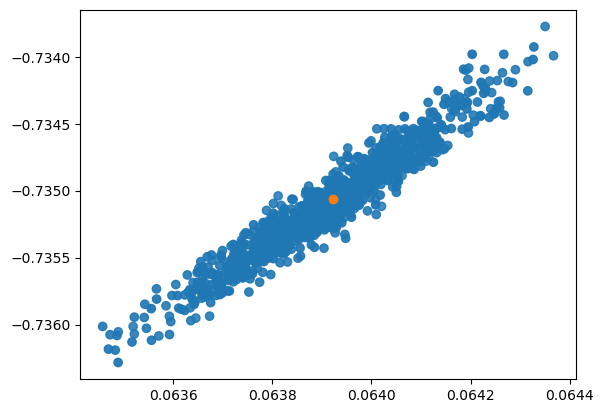

In [20]:
obs = data.observation[:, 0:1]
state = data.state[:, 0:1]
control = data.control[:, 0:1]
print(dynamic_params[0])
time = 3
batch = 0
encoded_obs = SSM.observation_model.encoder(obs.reshape(obs.size(0)*obs.size(1), 3, 24, 24))
dpf.update()
with torch.inference_mode():
    ps = dpf(1000, 99, {'state': pydpf.State(), 'weight': pydpf.Weight()}, observation=encoded_obs.reshape(100, 1, encoded_obs.size(1)).contiguous(), ground_truth=state, control=control)
numpy_ps = ps['state'].detach().cpu().numpy()
numpy_weight = ps['weight'].detach().cpu().numpy()
#print(numpy_weight[0, 0, :])
plt.scatter(numpy_ps[time,batch,:,0], numpy_ps[time,batch,:,1], alpha=np.exp(numpy_weight[time, batch, :])/np.max(np.exp(numpy_weight[time, batch, :])))
plt.scatter(state.cpu().numpy()[time,batch,0], state.cpu().numpy()[time,batch,1])
print(numpy_ps.shape)
#plt.xlim(-1, 1)
#plt.ylim(-1, 1)
plt.show()